In [37]:
import pandas as pd
import numpy as np
from pandas import datetime
import matplotlib.pyplot as plt
%matplotlib inline

C:\Users\HP\AppData\Local\Temp/ipykernel_9824/950759743.py:3: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


In [38]:
df=pd.read_csv('gold_price_data.csv',index_col=0,parse_dates=True)
df.head()

,Value
Date,
1970-01-01,35.2
1970-01-04,35.1
1970-01-07,35.4
1970-01-10,36.2
1971-01-01,37.4


In [39]:
df.columns

Index(['Value'], dtype='object')

<AxesSubplot:xlabel='Date'>

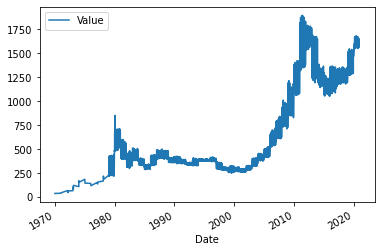

In [40]:
df.plot()

In [41]:
df.isna().sum()

Value    0
dtype: int64

In [42]:
timeSeries = df.copy()

array([[<AxesSubplot:title={'center':'Value'}>]], dtype=object)

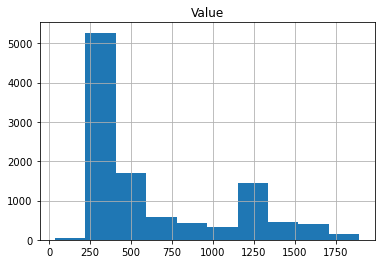

In [43]:
timeSeries.hist()

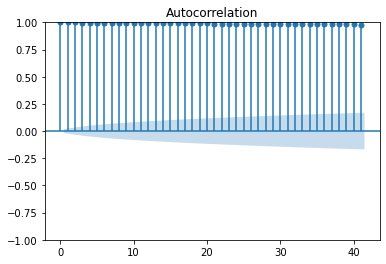

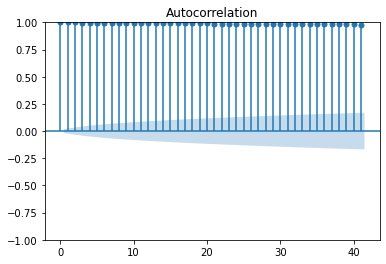

In [44]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(timeSeries)

In [45]:
timeSeries.shape

(10787, 1)

In [46]:
data1 = timeSeries[0:5394]
data2 = timeSeries[5394:]

In [47]:
data1.size
data2.size

5393

In [48]:
data1.mean()

Value    381.351481
dtype: float64

In [49]:
data2.mean()

Value    925.892268
dtype: float64

In [50]:
data1.var()

Value    6167.576533
dtype: float64

In [51]:
data2.var()

Value    222363.129839
dtype: float64

In [52]:
timeSeries.values

array([[  35.2 ],
       [  35.1 ],
       [  35.4 ],
       ...,
       [1653.75],
       [1570.7 ],
       [1562.8 ]])

In [53]:
from statsmodels.tsa.stattools import adfuller

In [54]:
test_result=adfuller(timeSeries['Value'])

In [55]:
def adfuller_test(Value):
    result=adfuller(Value)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )

if test_result[1] <= 0.05:
    print("Data is stationary")
else:
    print("Data is non-stationary ")

adfuller_test(timeSeries['Value'])

Data is non-stationary 
ADF Test Statistic : -0.07112124453813365
p-value : 0.9522400769147396
#Lags Used : 39
Number of Observations : 10747


In [29]:
timeSeries_First_Difference = timeSeries.diff().dropna()

In [56]:
timeSeries['First Difference'] = timeSeries['Value'] - timeSeries['Value'].shift(1)

In [57]:
timeSeries['Seasonal First Difference']=timeSeries['Value']-timeSeries['Value'].shift(12)

In [68]:
timeSeries.head(20)

,Value,First Difference,Seasonal First Difference
Date,,,
1970-01-01,35.2,NaN,NaN
1970-01-04,35.1,-0.1,NaN
1970-01-07,35.4,0.3,NaN
1970-01-10,36.2,0.8,NaN
1971-01-01,37.4,1.2,NaN
1971-01-04,38.9,1.5,NaN
1971-01-07,40.1,1.2,NaN
1971-01-10,42.0,1.9,NaN
1972-03-01,43.5,1.5,NaN


In [59]:
adfuller_test(timeSeries['Seasonal First Difference'].dropna())

ADF Test Statistic : -14.980483866744715
p-value : 1.1640981457203492e-27
#Lags Used : 39
Number of Observations : 10735


In [60]:
adfuller_test(timeSeries['First Difference'].dropna())

ADF Test Statistic : -17.568807521617266
p-value : 4.061374360447349e-30
#Lags Used : 38
Number of Observations : 10747


<AxesSubplot:xlabel='Date'>

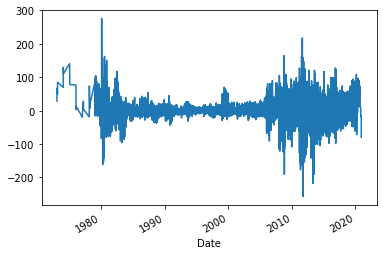

In [62]:
timeSeries['Seasonal First Difference'].plot()

<AxesSubplot:xlabel='Date'>

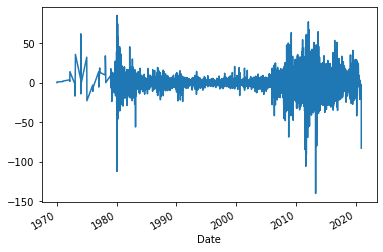

In [66]:
timeSeries['First Difference'].plot()

In [67]:
X = timeSeries.values
X.size
# train = X[0:9999] # 40 data as train data
# test = X[9999:]  # 9 data as test data
# predictions = []

32361